# Table of Contents
* [Vive Validation](#Vive-Validation)
	* [Dropped Pulse Errors](#Dropped-Pulse-Errors)
* [Validating Pulse Classification](#Validating-Pulse-Classification)
* [Normal Distance Variation](#Normal-Distance-Variation)
* [Light Interference](#Light-Interference)
* [Min Distance](#Min-Distance)
* [Max Distance](#Max-Distance)
* [Sensor Angle](#Sensor-Angle)
* [Base Station Angle](#Base-Station-Angle)
* [Error Rate During Continuous Motion](#Error-Rate-During-Continuous-Motion)
* [Change in Angle with Distance](#Change-in-Angle-with-Distance)
* [Dependence of Angle-Reading on Sensor Distance](#Dependence-of-Angle-Reading-on-Sensor-Distance)
	* [Measure angle from middle of signal peak instead?](#Measure-angle-from-middle-of-signal-peak-instead?)
* [Verifying Pulse Classification](#Verifying-Pulse-Classification)
	* [Improvements and Suggestions](#Improvements-and-Suggestions)
* [Conclusion](#Conclusion)


# Vive Validation

The following script is written to validate the components of the Vive-based positioning system and estimate the overall accuracy obtained and limits of operation. The script is designed to take a file containing the serial-output from the verbose debug-mode of the Teensy program. To enter debug mode you plug the Teensy-board to power with a jumper between ports 11 and 12. When launched, double-press the button to enter verbose mode. 

The file [Parsing](Vive Validation Resources/Parsing.py) reads the output format, while [Visualizing](Vive Validation Resources/Visualizing.py) contains a series of helper-methods to make it easy to plot the data. 

In [1]:
# Importing dependencies
%run "Vive Validation Resources/Parsing.py"
%run "Vive Validation Resources/Visualizing.py"

import warnings
warnings.filterwarnings('ignore')

# Set appropriate figure size
%matplotlib notebook
%pylab inline

pylab.rcParams['figure.figsize'] = (15, 6)

Populating the interactive namespace from numpy and matplotlib


## Dropped Pulse Errors

The dropped pulse errors table prints an overview of the number of pulses dropped by the system, enabling us to determine which component causes the drop. The information in the columns is here further explained: 
- Count: number of pulses received in print b.
- Lost pulses: number of pissing pulse-starts based on expected BstartTime. 
- Error-rate: lost pulses / (count + lost pulses)
- Signal-gaps: number of continuous pulse-loss periods.

# Validating Pulse Classification

For this initial test, we use the roof-mounted base stations and position the Vive system between them. The digital signal read by the Arduino is monitored by falling/rising edge interrupts that record the timing-information for each input pulse. A histogram of the pulse-widths is seen below. The next graph uses the package-recognition functionality in the Teensy code to determine which pulses originate from the master and slave base stations and plots the pulse-widths accordingly.

We see that pulses of varying length are detected, in what corresponds to the range of the calibration-pulses as well as the signal pulses. In the first plot, there is not eight distinct pulse-widths to be observed, but a series of double spikes. When we in the second graph separate the signals from the master and the slave base station, we see that this double-spike behavior is caused by there being a constant shift between the pulse-widths from the two. This is something we account for in our classifier by determining the pulse-class from the longest/shortest calibration pulses received from the n most recent pulses. 

Note: The discrete values for pulse-length observed here is caused by an integer division to result in truncation and loss of accuracy. This has been updated to a floating point deviation operation, resulting in a much better resolution to the pulse-widths.

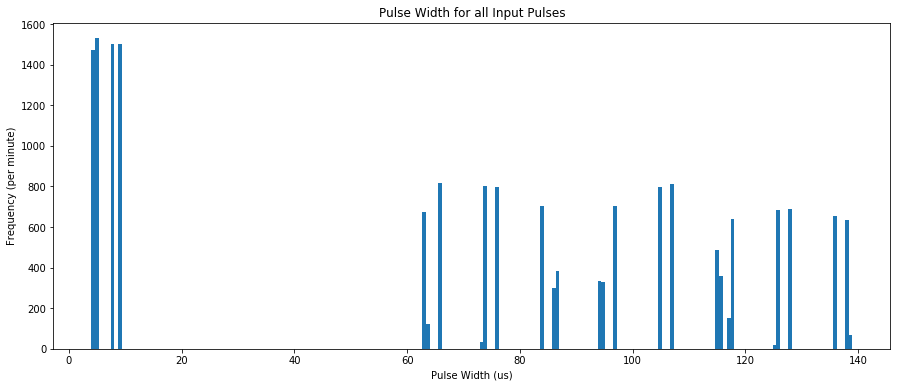

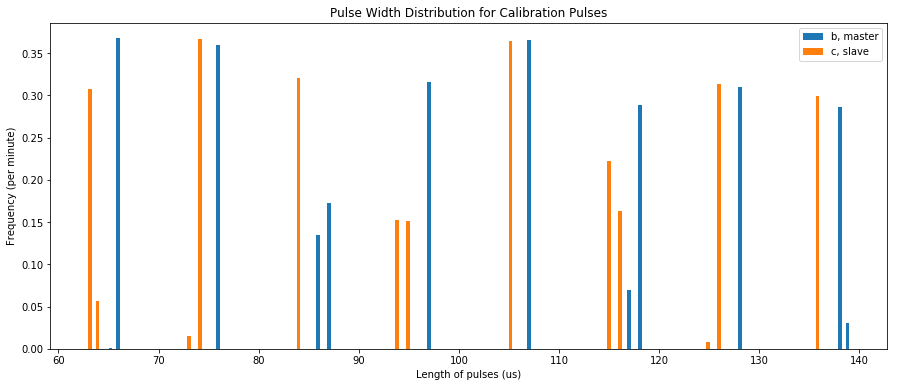

In [2]:
filename = "01"
data = Data.readFile(filename)

plt.figure()
plt.hist(data[-1].Aduration, bins=200)
plt.xlabel("Pulse Width (us)") 
plt.ylabel("Frequency (per minute)") 
plt.title("Pulse Width for all Input Pulses")

plt.figure()
plt.hist(data[-1].BL1, bins=200, normed=True)
plt.hist(data[-1].BL2, bins=200, normed=True)
plt.xlabel("Length of pulses (us)") 
plt.ylabel("Frequency (per minute)") 
plt.legend(["b, master", "c, slave"])
plt.title("Pulse Width Distribution for Calibration Pulses")

cPulses = []
for d in data[-1].Aduration:
    if d > 60:
        cPulses.append(d)

# Normal Distance Variation

The following data was collected with the base stations mounted in the roof at 6 meters distance and in opposite corners of the room. The sensor was mounted on a camera tripod 1.3 meters below the roof. The tripod was then positioned under one base-station and moved across the room in 30 cm steps. 1 minute of data was recorded for each position. For simplicity, we only consider the angles from the master base station (the results for the slave is very similar).

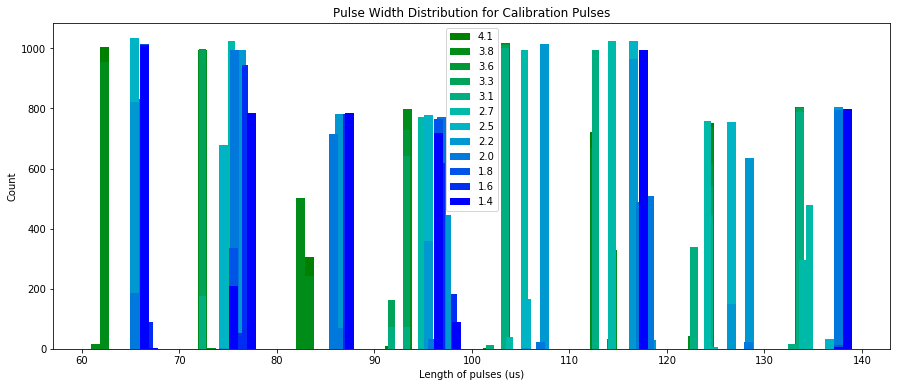

In [3]:
data = Data.readFile("02")
distanceL1 = [4.1, 3.8, 3.6, 3.3, 3.1, 2.7, 2.5, 2.2, 2.0, 1.8, 1.6, 1.4]
distanceL2 = [1.3, 1.4, 1.6, 1.8, 2.0, 2.3, 2.5, 2.8, 3.1, 3.3, 3.6, 3.9]

plotCalibrationPulseWidths(data, distanceL1)

We see the pulse-widths fall into 8 distinct classes (despite variations between data-sets). 

There should be $30 \text{ pulses} / \text{second} * 60 \text{ seconds} = 1800 \text{ pulses}$ arriving per angle. Due to the data-bit, this will be split between two angle readings, giving on average $900$ pulses that we expect in each class. We know the data-pulse is the second most significant bit (see table below) of the signal-distribution, so the pattern where we see $j0$ receive about $1000$ pulses in the given period while $j1$ receives about $800$ pulses etc. makes sense - they sum to $1800$, giving the expected number of pulses coming in for each angle. A breakdown of the average pulse length for each signal class is here: 

Name | skip | data | axis  | length (ticks) | length (µs)
-----|------|------|-------|----------------|------------
j0   | 0    | 0    | 0     | 3000           | 62.5
k0   | 0    | 0    | 1     | 3500           | 72.9
j1   | 0    | 1    | 0     | 4000           | 83.3
k1   | 0    | 1    | 1     | 4500           | 93.8
j2   | 1    | 0    | 0     | 5000           | 104
k2   | 1    | 0    | 1     | 5500           | 115
j3   | 1    | 1    | 0     | 6000           | 125
k3   | 1    | 1    | 1     | 6500           | 135

Interestingly, we see the data-points collected in the middle of the two base-stations (eg. 2.5 meters) have a significant number of dropped packages. This could result form the large angles between the sensor and the base-stations that was present when collecting data at these locations. This was later discovered to be caused by the comparator being set too high so that large incident-angles on the sensor did not trigger a the registration of a digital pulse. When lowering the comparator value the system is seen to be able to work with significantly larger angles. 

In order to more clearly asses the correspondence between pulse-width/sensor distance and classification-algorithm the following plot was made. The black dots correspond to the data-points collected, and the colored lines to the mean pulse width of each pulse-class.

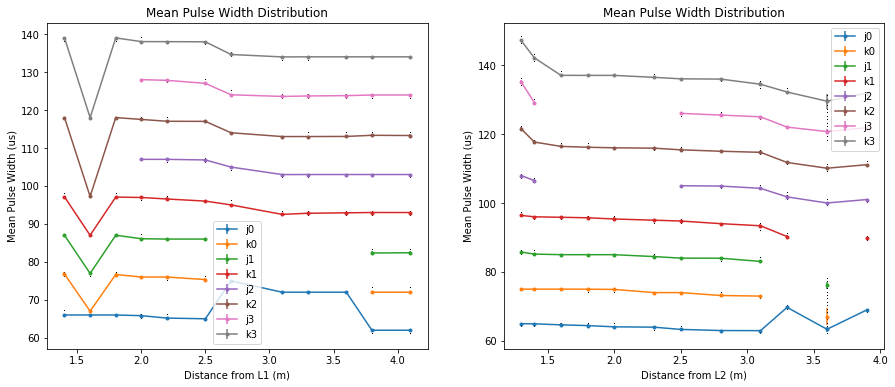

In [4]:
plotPulseWidthsForData(data, distanceL1, distanceL2)

We see a clear classification for the bands where we have signals in all eight classes. Where the longest or shortest pulses are missing, this system breaks down which is to be expected given our implementation. This breakdown is acceptable, as we assume that the package-arrival-time will be calibrated in a region where it is able to receive readings from all angles.

If we look at the numerical error for this data-set, we confirm that there is reception-issues for certain angles. A large number of the positions lack about $1800$ data-points, suggesting one of the four angles have not been measured at all. From this we again conclude that the issue is systematic and related to input-angle on the sensor and/or other factors.

When we use the measured-angle breakdown for this data-set we see that while $Bv$ (angle in the vertical plane from the master base station) is the angle that is missing the most, this is not always the case.

┌────────────────────┬───────────────┬──────────────┬───────────────┐
│ # collected points │ # lost points │ % error rate │ # signal gaps │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 7199               │ 1             │ 0            │ 2             │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 7111               │ 89            │ 1            │ 88            │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 5396               │ 1803          │ 25           │ 1802          │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 5398               │ 1799          │ 24           │ 1800          │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 3920               │ 3276          │ 45           │ 1799          │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 5396               │ 1803          │ 25           │ 1800          │
├───────────────────

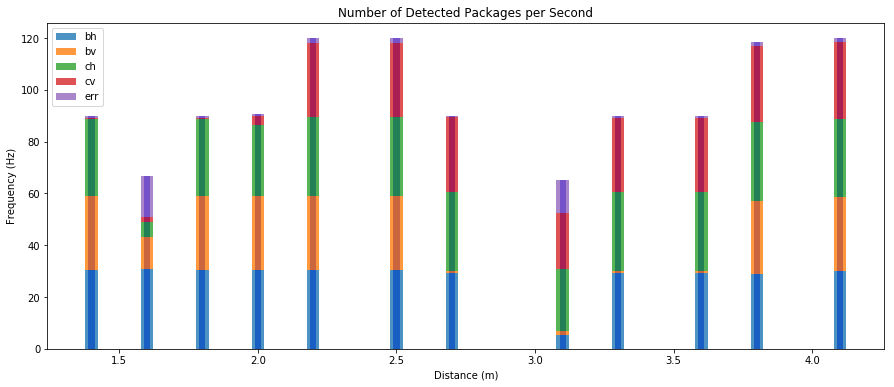

In [5]:
printDroppedPulseErrors(data)

xLabel = 'Distance (m)'
plotSignalCount(data, distanceL1, xLabel, anglesLabel)

From this we conclude that the signal-classification seems to work well when we are measuring all angles. There is a significant problem present with regards to signal reception. 

Note: The poor signal reception for large angles of incidence on the sensor has been resolved through lowering the comparator-value on the Teensy so as to allow for the detection of weaker signal-pulses from the rotating line-lasers. This issue has thus been resolved for normal operating angles. 

# Light Interference

To evaluate the performance of the system with interference, data-points are collected with/without light on and with/without blinds down. During the capture the sky was blue, but no direct sunlight came through the window.

The angles measured in the different situations are identical and the differences in pulse-withs seems to be very small - we can confidently conclude normal light sources will not disturb the system. We do however observe that when direct sunlight falls on the sensor, the OpAmps get fully saturated so that the input rests at a permanent high and no information is as a consequence detected. 

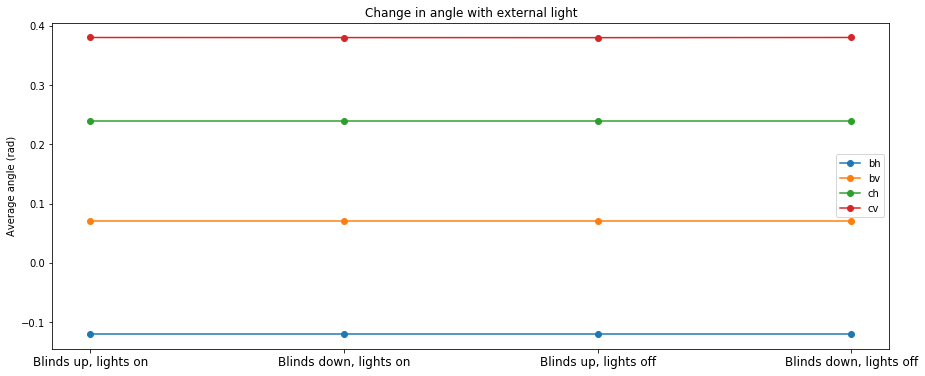

In [6]:
data = Data.readFile("05")

y = [[np.mean(np.array(data[i].angles)[:,j]) for j in range(4)] for i in range(4)]
xLabel = ["Blinds up, lights on","Blinds down, lights on","Blinds up, lights off","Blinds down, lights off"]

plt.plot(range(len(data)), y, 'o-')
plt.xticks(range(len(data)), xLabel, size='large')
plt.legend(anglesLabel)
plt.title("Change in angle with external light")
plt.ylabel("Average angle (rad)")

# Min Distance

In order to determine the minimum operation distance of the system, two base-stations was positioned next to each other with a wired sync-cable (requiring one base-station to be in mode $b$ while the other is switched to $A$). The sensor was mounted on a tripod located directly in front of the master and moved backward in 10 cm increments, starting at a 40 cm distance from the base-stations.

We see a very clear correlation between calibration pulse width and base-station distance. When the sensor is very close, the difference is huge while the rate of change rapidly decreases as we reach a more normal operation distance.

All distances larger than 0.8 m is here seen to give clean data. The systematic change in signal with distance is not important, as the sensor was not kept directly in front of the base station. 

The smaller number of signals measured for 1.1 m was caused by a pulse arriving outside the expected pulse-arrive window. This caused the system to recalibrate, not performing D-data print for a small duration.

600 556
[3]
┌────────────────────┬───────────────┬──────────────┬───────────────┐
│ # collected points │ # lost points │ % error rate │ # signal gaps │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 526                │ 74            │ 12           │ 74            │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 558                │ 42            │ 7            │ 42            │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 598                │ 2             │ 0            │ 2             │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 600                │ 0             │ 0            │ 0             │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 598                │ 2             │ 0            │ 2             │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 600                │ 0             │ 0            │ 0             │
├───────

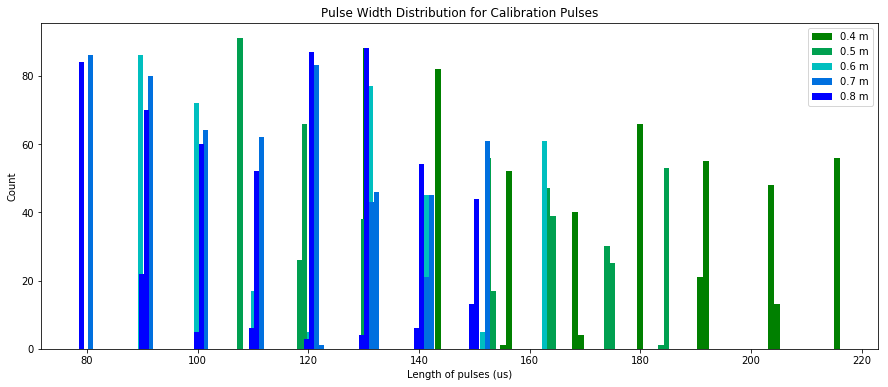

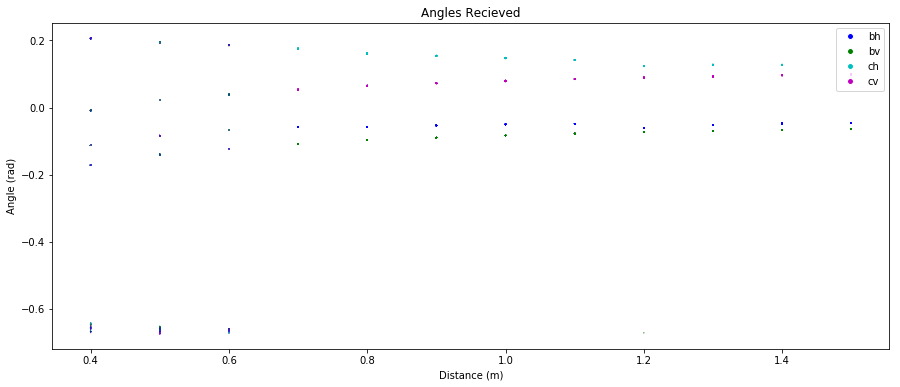

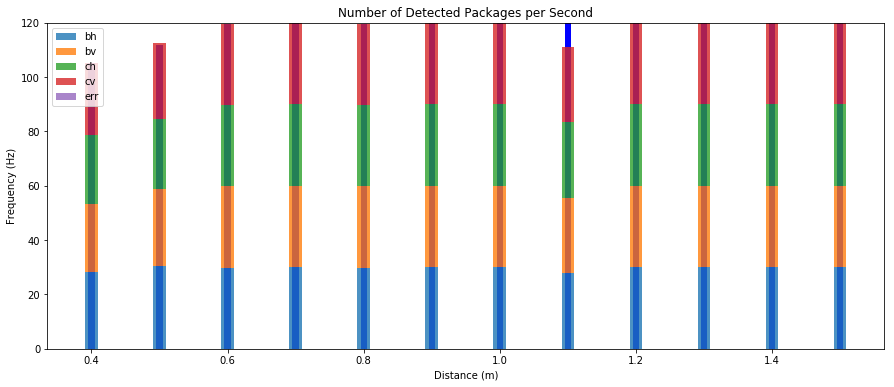

In [7]:
data = Data.readFile("03-1")
distance = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
xLabel = "Distance (m)"

last = 5
plotCalibrationPulseWidths(data[0:last], withUnit(distance,'m')[0:last])        
plotSignalValue(data, distance, xLabel)
plotSignalCount(data, distance, xLabel, anglesLabel)

print len(data[7].CsignalType), len(data[7].DsignalType)
print data[7].errors
printDroppedPulseErrors(data)

# Max Distance

With procedure like to that used for min-distance, the max-distance of the system was determined.

We see there is no signals detected past 5.5 meters, and that only a few signals are collected at 5.5 meters.

┌────────────────────┬───────────────┬──────────────┬───────────────┐
│ # collected points │ # lost points │ % error rate │ # signal gaps │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 599                │ 1             │ 0            │ 1             │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 599                │ 1             │ 0            │ 1             │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 600                │ 0             │ 0            │ 2             │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 0                  │ 0             │ 100          │ 0             │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 186                │ 412           │ 68           │ 119           │
└────────────────────┴───────────────┴──────────────┴───────────────┘


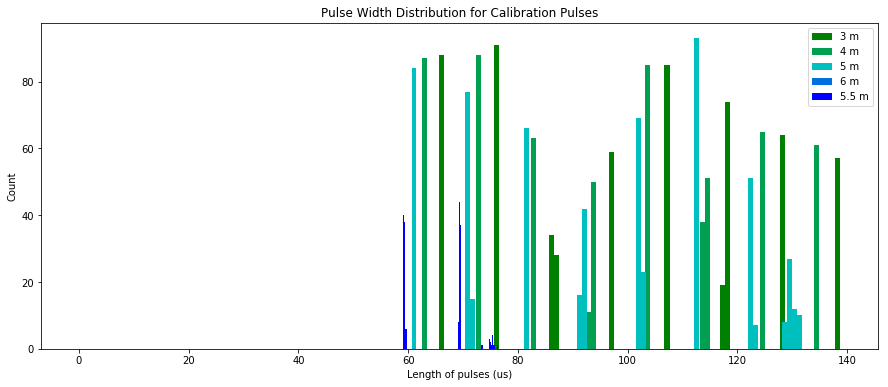

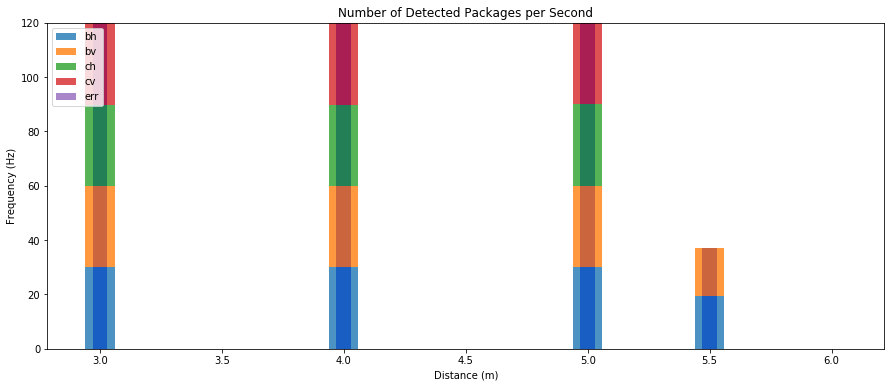

In [8]:
data = Data.readFile("03-2")
distance = [3, 4, 5, 6, 5.5]
xLabel = "Distance (m)"

plotCalibrationPulseWidths(data, withUnit(distance,'m'))        
plotSignalCount(data, distance, xLabel, anglesLabel)
printDroppedPulseErrors(data)

# Sensor Angle 

To determine the signal-integrity at different sensor angles, the sensor was taped to a angle-measurement device and rotated through 180˚ from +90˚ to -90˚ both horizontally and vertically.

We see that sensor-rotation has little effect on the number of detected packages and pulse-durations when we operate within suitable bounds (±60˚). There is an asymmetry in the operation of the sensor from left to right, but this difference is likely primarily caused by mechanical shielding from misalignment between the base-stations and the sensor during the test-setup. 

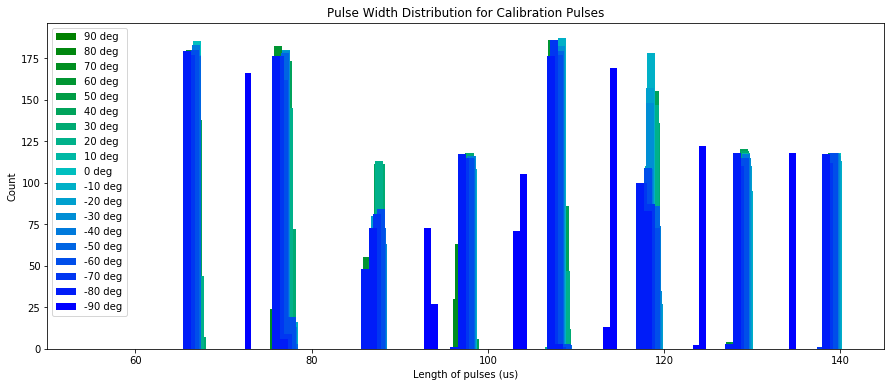

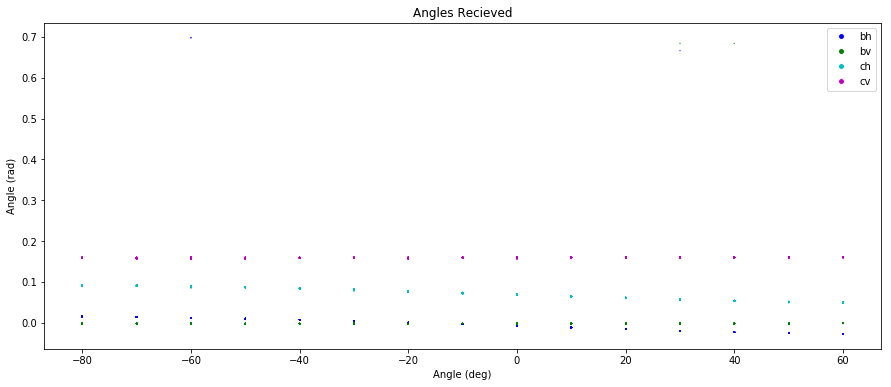

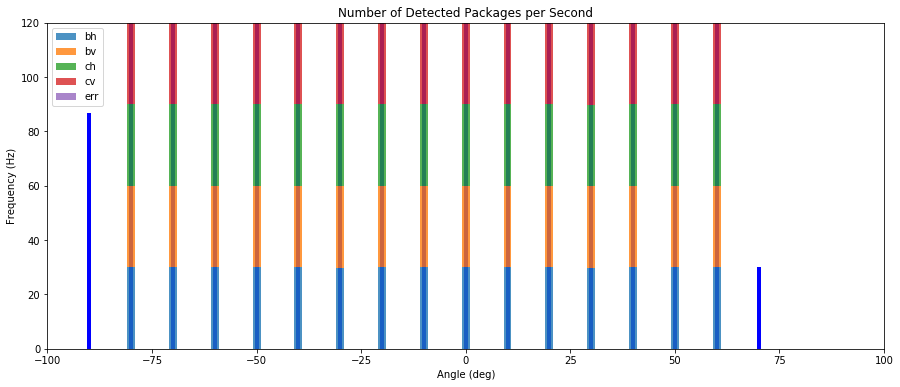

In [9]:
# Horizontal
data = Data.readFile("06-1")
angle = [90,80,70,60,50,40,30,20,10,0,-10,-20,-30,-40,-50,-60,-70,-80,-90]
xLabel = "Angle (deg)"

plotCalibrationPulseWidths(data, withUnit(angle,'deg'))   
plt.xlim((50,145))
plotSignalValue(data, angle, xLabel)
plotSignalCount(data, angle, xLabel, anglesLabel)

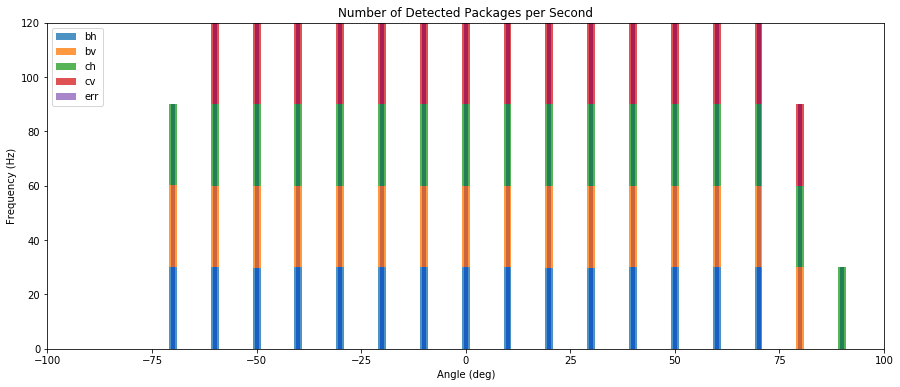

In [10]:
# Vertical
data = Data.readFile("06-2")
angle = [90,80,70,60,50,40,30,20,10,0,-10,-20,-30,-40,-50,-60,-70,-80,-90]
xLabel = "Angle (deg)"

plotSignalCount(data, angle, xLabel, anglesLabel)

# Base Station Angle

To determine the signal-integrity at different sensor angles, the sensor was screwed/taped to a angle-measurement device and rotated through both horizontally and vertically. We observe that the measurenments are very accurate, but that there is a systematic error present. 

The following factors have been determined to not impact this systematic deviations significantly: 
- different days
- different locations
- wether the base station is operating as master or slave

whereas these factors do cause a notisable change:
- which base-station is used
- which angle (horizontal or vertical) of the base station is being measured
- the orientation of the base-station

We have not been able to determine the root cause of this, but are left to assume there is some in-perfection in the operation of the base stations (a systematic non-constant rotational speed, imperfections in the line-laser mirrors, imperfection in the cover-class etc.).

Slopes: 
- Base-station 1 horisontal:	[0.0031731469335398474, 0.0031550542198404896]  	average:  0.00316410057669
- Base-station 1 vertical	[-0.0011194102856160436, -0.0016120181884123547]  	average:  -0.00136571423701
- Base-station 2 horisontal:	[0.0014562612612992367, 0.0014248254793904295]  	average:  0.00144054337034
- Base-station 2 vertical:	[-0.0028098547995621869, -0.00352271006898366]  	average:  -0.00316628243427
- Average slope across all measurenments:  1.8161818937e-05  	 Variance:  5.99397452134e-06


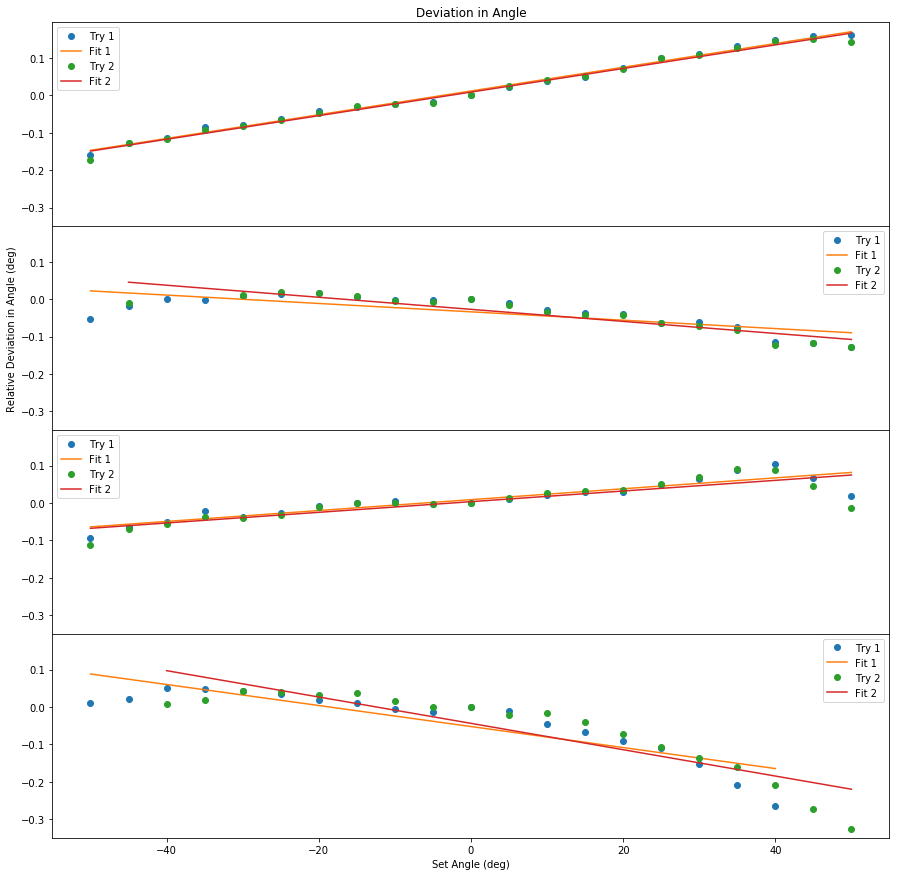

In [11]:
AN = []
AS = []
BN = []
BS = []

f, axarr = plt.subplots(4, sharex=True, sharey=True)
xLabel = "Angle (deg)"

data = Data.readFile("AngAN2")
angle = (50-np.array(range(len(data))).astype(double) * (100.0/(len(data)-1)))
AN.append(compareAngles(angle, data, 2, axarr, 0))

data = Data.readFile("AngAN3")
angle = -(50-np.array(range(len(data))).astype(double) * (100.0/(len(data)-1)))
AN.append(compareAngles(angle, data, 2, axarr, 0))

data = Data.readFile("AngAS1")
angle = -(50-np.array(range(len(data))).astype(double) * (100.0/(len(data)-1)))
AS.append(compareAngles(angle, data, 3, axarr, 1))

data = Data.readFile("AngAS2")
angle = (50-np.array(range(len(data))).astype(double) * (100.0/(len(data)-1)))
angle = np.hstack((angle[0:-4], angle[-2:-1]))
data = np.hstack((data[0:-4], data[-2:-1]))
AS.append(compareAngles(angle, data, 3, axarr, 1))

data = Data.readFile("AngBN1")
angle = (50-np.array(range(len(data))).astype(double) * (100.0/(len(data)-1)))
BN.append(compareAngles(angle, data, 0, axarr, 2))

data = Data.readFile("AngBN2")
angle = -(50-np.array(range(len(data))).astype(double) * (100.0/(len(data)-1)))
BN.append(compareAngles(angle, data, 0, axarr, 2))

data = Data.readFile("AngBS4")
angle = -(50-np.array(range(len(data))).astype(double) * (90.0/(len(data)-1)))
BS.append(compareAngles(angle, data, 1, axarr, 3))

data = Data.readFile("AngBS5")
angle = (50-np.array(range(len(data))).astype(double) * (90.0/(len(data)-1)))
BS.append(compareAngles(angle, data, 1, axarr, 3))

f.subplots_adjust(hspace=0)
f.set_figheight(15)

for a in axarr:
    a.legend(['Try 1', 'Fit 1', 'Try 2', 'Fit 2'])

axarr[0].set_title('Deviation in Angle')
axarr[3].set_xlabel('Set Angle (deg)')
axarr[1].set_ylabel('Relative Deviation in Angle (deg)')

print "Slopes: "
print "- Base-station 1 horisontal:\t", AN, " \taverage: ", np.mean(AN)
print "- Base-station 1 vertical\t", AS, " \taverage: ", np.mean(AS)
print "- Base-station 2 horisontal:\t", BN, " \taverage: ", np.mean(BN)
print "- Base-station 2 vertical:\t", BS, " \taverage: ", np.mean(BS)

s = [np.mean(AN), np.mean(AS), np.mean(BN), np.mean(BS)]
print "- Average slope across all measurenments: ", np.mean(s), " \t Variance: ", np.var(s)

The below graphs are collected from the same base-station and for the same angle, but with the base-station in the correct orientation (standing normally) and the base-station laying on it's side. As we can see, there is a significant difference between the two, with the normal orientation yielding the most linear result. 

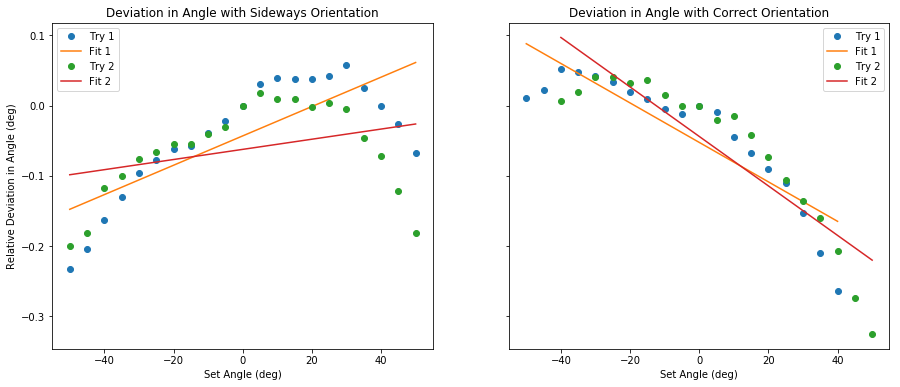

In [12]:
f, axarr = plt.subplots(1, 2, sharex=True, sharey=True)
xLabel = "Angle (deg)"

data = Data.readFile("AngBS2")
angle = (50-np.array(range(len(data))).astype(double) * (100.0/(len(data)-1)))
compareAngles(angle, data, 1, axarr, 0)

data = Data.readFile("AngBS3")
angle = -(50-np.array(range(len(data))).astype(double) * (100.0/(len(data)-1)))
xLabel = "Angle (deg)"
compareAngles(angle, data, 1, axarr, 0)

data = Data.readFile("AngBS4")
angle = -(50-np.array(range(len(data))).astype(double) * (90.0/(len(data)-1)))
xLabel = "Angle (deg)"
compareAngles(angle, data, 1, axarr, 1)

data = Data.readFile("AngBS5")
angle = (50-np.array(range(len(data))).astype(double) * (90.0/(len(data)-1)))
xLabel = "Angle (deg)"
BS.append(compareAngles(angle, data, 1, axarr, 1))

f.subplots_adjust(hspace=0)

for a in axarr:
    a.legend(['Try 1', 'Fit 1', 'Try 2', 'Fit 2'])

axarr[0].set_title('Deviation in Angle with Sideways Orientation')
axarr[1].set_title('Deviation in Angle with Correct Orientation')

axarr[0].set_xlabel('Set Angle (deg)')
axarr[1].set_xlabel('Set Angle (deg)')

axarr[0].set_ylabel('Relative Deviation in Angle (deg)')

In an attempt to investigate a possible correlation between the arrival-time of each package and the angle to see if there is a systematic drift as we rotate the base-station we obtain the following histogram. We see what seems to behave like a normal distribution around the expected $8333.33 \mu s$. The variance in the signal is small, and of an order of magnitude smaller than the systematic perturbation we are seeing in the signal. 

Mean:  8333.39098921  Variance:  0.000190039580669


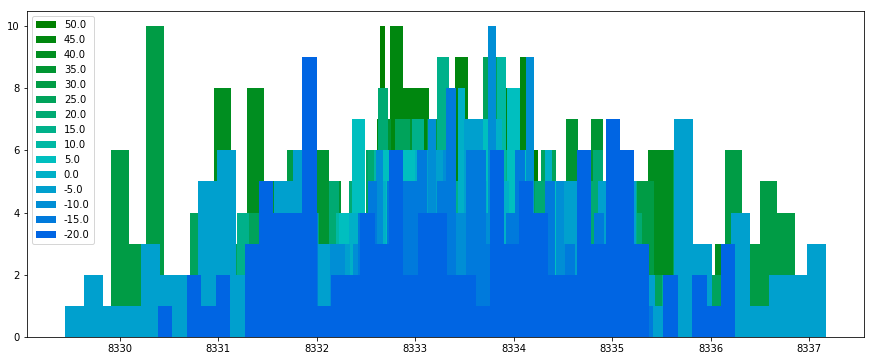

In [13]:
colours = colourRange(len(data))

mean = []
def plotPulseDuration(d):
    p = [np.array(d.BstartTime[i+1]) - np.array(d.BstartTime[i]) for i in range(len(d.BstartTime)-1)]
    f = []
    if np.var(p) > 5:
        return
    for l in p:
        if l < 10000:
            f.append(l)
    
    plt.hist(f,bins=40, color=colours.pop().hex_l)
    mean.append(np.mean(f))

plt.figure()
for d in data:
    plotPulseDuration(d)
plt.legend(angle)

print "Mean: ", np.mean(mean), " Variance: ", np.var(mean)

# Error Rate During Continuous Motion

In order to evaluate the performance of the system during a scenario more reminiscent to that of the application, we move the sensor around in the room continuously while capturing data for one minute over the serial-port. 

The fist graph is plotted using data-sets collected with the initial system-configuration. We see a very clear issue arise with regards to lost readings, causing large gaps in the signal. 

In order to investigate this issue we attempted to use three sensors simultaneously (all pointing in different directions), but this still left blind-spots. We next connected the sensor and comparator output to the oscilloscope and realized the issue would be solved by lovering the comparator-value. The potential issues with loss of accuracy from ramp on analog signal is small and this drastically improved reception as can be seen in the second graph below. 

The second graph do however have issues with discontinuity in certain angles. This is caused by reflection, and implementing a system for selecting the widest (most powerful) signal pulse enabled us to pick out the right signal pulse when we have multiple arriving for a given package. 

The third graph is the performance of the system as of 18. Aug 2017. There is few packages lost and there is no reflections present. 

Initial Configuration
┌────────────────────┬───────────────┬──────────────┬───────────────┐
│ # collected points │ # lost points │ % error rate │ # signal gaps │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 5881               │ 1260          │ 17           │ 786           │
└────────────────────┴───────────────┴──────────────┴───────────────┘
error

With Lowered Comparator
┌────────────────────┬───────────────┬──────────────┬───────────────┐
│ # collected points │ # lost points │ % error rate │ # signal gaps │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 7200               │ 17            │ 0            │ 19            │
└────────────────────┴───────────────┴──────────────┴───────────────┘

With Reflection-Handeling
┌────────────────────┬───────────────┬──────────────┬───────────────┐
│ # collected points │ # lost points │ % error rate │ # signal gaps │
├────────────────────┼───────────────┼──────────────┼───────────────┤
│ 7497    

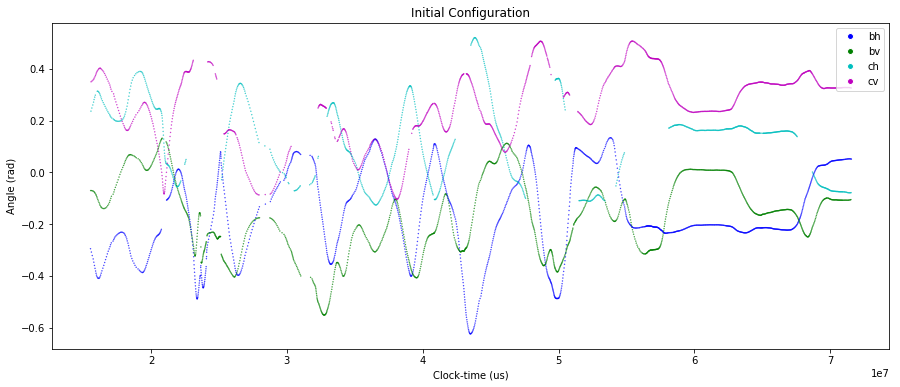

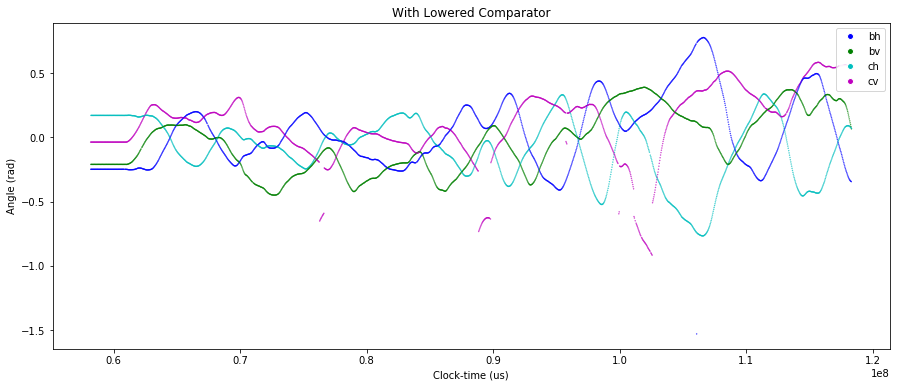

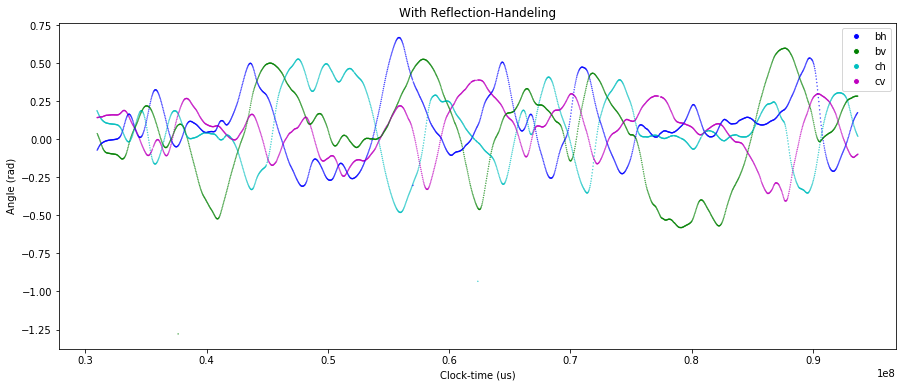

In [14]:
print 'Initial Configuration'
data = Data.readFile("07-5")
printDroppedPulseErrors(data)
plt.figure()
plotAngles(data[0].DsignalAngle, data[0].DsignalType, data[0].BstartTime)
plt.title('Initial Configuration')

print '\nWith Lowered Comparator'
data = Data.readFile("Cont1")
printDroppedPulseErrors(data)
plt.figure()
plotAngles(data[0].DsignalAngle, data[0].DsignalType, data[0].BstartTime)
plt.title('With Lowered Comparator')

print '\nWith Reflection-Handeling'
data = Data.readFile("Cont2")
printDroppedPulseErrors(data)
plt.figure()
plotAngles(data[0].DsignalAngle, data[0].DsignalType, data[0].BstartTime)
plt.title('With Reflection-Handeling')


# Dependence of Angle-Reading on Sensor Distance 

In order to determine whether the distance has an impact on the angle-reading as could be indicated by the earlier distance-readings, a distance-measuring laser is positioned at the exact center of a base-station and the laser-beam pointed at an exact line going through the sensor. When moving the sensor away from the base-station, the sensor is moved so that the laser is always kept on the vertical axis going through the sensor. 

The pulse-widths decrease with increasing length from the base-stations as expected. We do however see a decrease in pulse-length at around 1 meter - the cause of this is unknown but it is a minor point as the classifier still functions.

There is a discernible increase in angle as the sensor moves away from the base-station, but the difference is on the order of $0.006 rad \approx 0.3 deg$ and is as such fairly insignificant. We also see that a significant change in angle only occurs for readings performed closer than 2 meters. We therefore conclude that the angle does not depend on distance when operating in the normal range.

LH angle deviation: -0.315142431561 deg


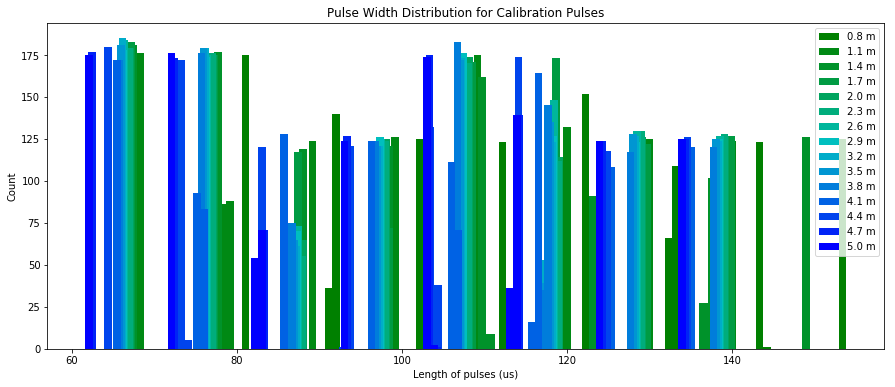

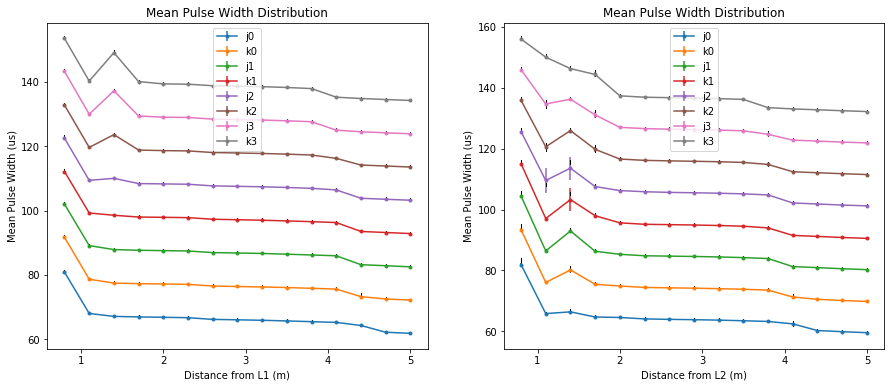

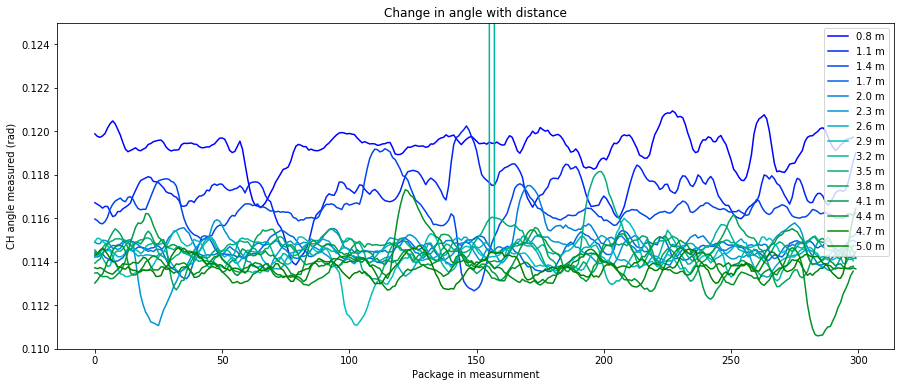

In [15]:
data = Data.readFile("08")
distance = np.array(range(len(data)))*.3+.8
xLabel = "Distance (m)"

plotCalibrationPulseWidths(data, withUnit(distance,'m'))
plotPulseWidthsForData(data, distance)

# Determine change in angle
plt.figure()

blue = Color("blue")
colours = list(blue.range_to(Color("green"),len(data)))
lhs = []
for j in range(len(data)):
    d = data[j]
    lh = []
    for i in range(len(d.DsignalAngle)):
        if d.DsignalType[i] == 2: 
            lh.append(d.DsignalAngle[i])
    plt.plot(range(len(lh)), lh, c=colours[len(lhs)].hex_l)
    lhs.append(lh)
    
plt.ylim([.11,.125])
plt.legend(withUnit(distance, 'm'))
plt.title('Change in angle with distance')
plt.xlabel('Package in measurnment')
plt.ylabel('CH angle measured (rad)')

print "LH angle deviation: " + str((np.mean(lhs[-1]) -  np.mean(lhs[0]))*180/np.pi) + " deg"

## Measure angle from middle of signal peak instead?

Due to the potential change in start time, the question was raised as to whether it would be beneficial to determine the angle reading not from the rising edge of the appropriate line-laser peak, but form the middle of this peak. The following computes the middle distance of the data used to plot the graph above so that we can compare the two methods.

We see that there is significantly better accuracy from not taking the width of the pulse into account (here, difference is $0.015rad > 0.006rad$ for rising edge measurement above). This could be caused by the saturation of the OpAmp causing a delay for the signal to go back down again. We are left considering it beneficial to continue referencing the rising edge as we have been doing. 

LH angle deviation: -0.879848786076 deg


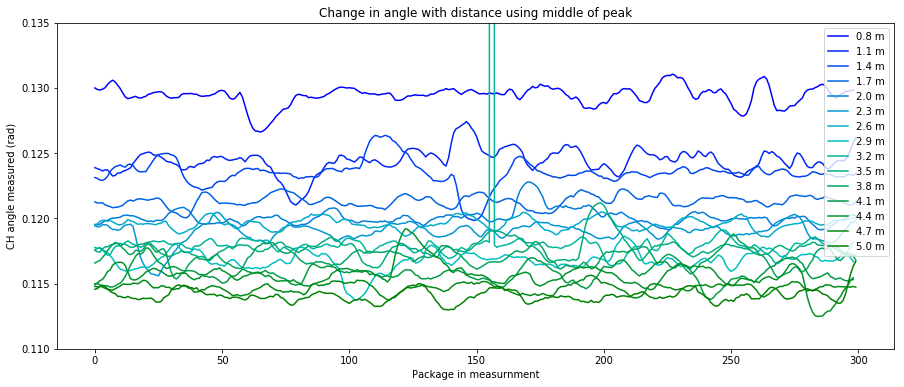

In [16]:
offset = [2,2,0,0,2,2,0,2,2,1,2,0,2,2,2]
signalPulseWidths = []
for j in range(len(data)):
    d = data[j]
    p = []
    for i in (np.array(range(len(d.AstartTime)/3))*3):
        p.append(d.Aduration[i+offset[j]])
    a = []
    for i in range((len(p)/4)-1):
        a.append([p[0+i*4], p[1+i*4], p[2+i*4], p[3+i*4]])
    b = np.array(a)
    signalPulseWidths.append(np.mean(b,0))

signalPulseWidths = np.array(signalPulseWidths)


# Determine change in angle
plt.figure()

blue = Color("blue")
colours = list(blue.range_to(Color("green"),len(data)))
lhs = []
for j in range(len(data)):
    d = data[j]
    lh = []
    for i in range(len(d.DsignalAngle)):
        if d.DsignalType[i] == 2: 
            pwa = 2 * signalPulseWidths[j,2] * 0.5 * 0.000120 * np.pi
            lh.append(d.DsignalAngle[i]+pwa)
    plt.plot(range(len(lh)), lh, c=colours[len(lhs)].hex_l)
    lhs.append(lh)
    
plt.ylim([.11,.135])
plt.legend(withUnit(distance, 'm'))
print "LH angle deviation: " + str((np.mean(lhs[-1]) -  np.mean(lhs[0]))*180/np.pi) + " deg"
plt.title('Change in angle with distance using middle of peak')
plt.xlabel('Package in measurnment')
plt.ylabel('CH angle measured (rad)')

# Verifying Pulse Classification

In order to verify that the pulses are classified correctly, we use two methods: 
1. comparing the two classifiers we have at hand, and
2. ensuring the angle-measurement for each angle makes sense (no jumps, discontinuities or switching of values). 

We begin by comparing the classifications on the data-set of varying distances form the base-station. We see there is a high degree of agreement between the two. This is sufficient, as the calibration only needs to get a given sequence calibrated correctly before the time-based classifier takes over. This initial pulse-width classification process will typically be done in a good operating-rage of the system, and will as such not have to be able to handle too large a range of distances. 

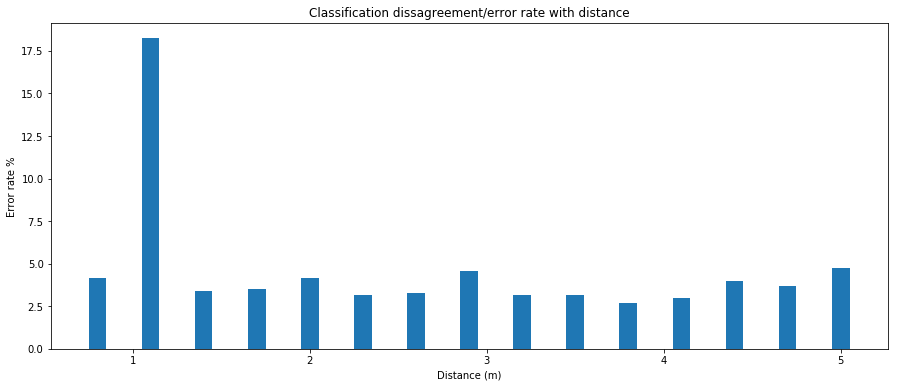

In [17]:
data = Data.readFile("08")
distance = np.array(range(len(data)))*.3+.8

errors = []
for d in data:
    if (not sum(len(d.DsignalType)- len(d.CsignalType))==0):
        print 'error'
    
    errorCount = 0
    for i in range(len(d.DsignalType)):
        if not d.DsignalType[i] == d.CsignalType[i]:
            errorCount += 1
    errors.append(float(errorCount) / len(d.DsignalType)*100)
plt.bar(distance, errors, 0.1)
plt.xlabel('Distance (m)')
plt.ylabel('Error rate %')
plt.title('Classification dissagreement/error rate with distance')

# Improvements and Suggestions

- There accuracy of the system is limited when moving away from the immediate volume surrounding the calibration-points. The cause of this is unknown and needs further investigation. 
- The calibration could be done using more point for increased accuracy. 
- There occasionally arrives stray angle-readings with a value significantly different from what it should be. What this is caused by is unclear, one possible source is when the timer overflows (occurs about once a minute).
- The status-led could have a better flashing-scheme to indicate the status of the system and for increased ease of operation. 
- A companion script could be written to read the verbose output and dynamically display the information to get a real-time diagnostic tool for the system.  

# Conclusion

The system perform is able to indicate positions with great accuracy with with limited accuracy when moving away from the immediate calibration-volume. It is very possible to use the system for navigation, but the user must be aware of this limitation and take it into account for the application. 

Differences in signal strength (and thus pulse-width) is:
  - little affected by external interference
  - little affected by base-station angle
  - little affected by sensor angle
  - little affected by distance between sensor and base station

The operational parameters of the system is here demonstrated to be as follows: 
- Range: 0.8 to 5 meters
- Base-station angle range: ± 55 deg 
- Sensor angle range: ± 60 deg (in both horizontal and vertical axis)
- Direct sunlight stops the system from working, but indirect sunlight and indoor lighting is generally not an issue 